In [1]:
import warnings; warnings.simplefilter('ignore')

This notebook requires **gpu** to run. See [mistral documentation](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2) for memory requirements. 

## 1. Data

In [2]:
from orion.data import load_signal

data = load_signal('exchange-2_cpm_results')
data.shape

(1624, 2)

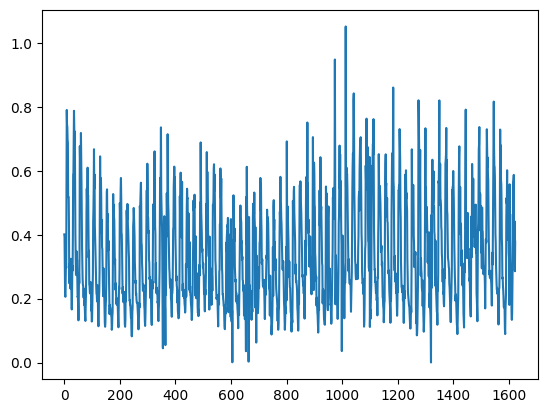

In [3]:
import matplotlib.pyplot as plt

plt.plot(data['value']);

if you want a quick test of how this pipeline works, uncomment the cell below
to save time. We will look at a small segment of the time series.

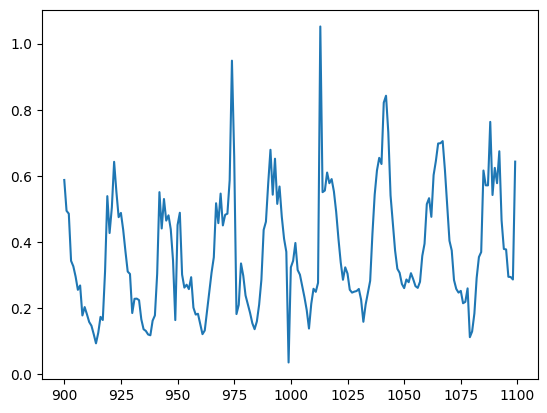

In [4]:
start = 900
end = start + 200

data = data.iloc[start: end]

plt.plot(data['value']);

## 2. Pipeline

In [5]:
from mlblocks import MLPipeline 

pipeline_name = 'mistral_detector'

pipeline = MLPipeline(pipeline_name)

2025-09-02 11:00:36.285384: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-02 11:00:36.318090: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-02 11:00:36.318119: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-02 11:00:36.318149: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-02 11:00:36.325125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

In [6]:
hyperparameters = {
    "mlstars.custom.timeseries_preprocessing.time_segments_aggregate#1": {
        "interval": 3600
    },
    "sigllm.primitives.forecasting.huggingface.HF#1": {
        "samples": 2
    },
    "sigllm.primitives.transformation.format_as_integer#1": {
        "trunc": 1,
        "errors": "coerce"
    }
}

pipeline.set_hyperparameters(hyperparameters)

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.00it/s]
Some parameters are on the meta device because they were offloaded to the cpu.


### step-by-step execution

MLPipelines are compose of a squence of primitives, these primitives apply tranformation and calculation operations to the data and updates the variables within the pipeline. To view the primitives used by the pipeline, we access its primtivies attribute.

The mistral-detector contains 11 primitives. we will observe how the context (which are the variables held within the pipeline) are updated after the execution of each primitive.

In [7]:
pipeline.primitives

['mlstars.custom.timeseries_preprocessing.time_segments_aggregate',
 'sklearn.impute.SimpleImputer',
 'sigllm.primitives.transformation.Float2Scalar',
 'sigllm.primitives.forecasting.custom.rolling_window_sequences',
 'sigllm.primitives.transformation.format_as_string',
 'sigllm.primitives.forecasting.huggingface.HF',
 'sigllm.primitives.transformation.format_as_integer',
 'sigllm.primitives.transformation.Scalar2Float',
 'sigllm.primitives.postprocessing.aggregate_rolling_window',
 'numpy.reshape',
 'orion.primitives.timeseries_errors.regression_errors',
 'orion.primitives.timeseries_anomalies.find_anomalies']

#### time segments aggregate
this primitive creates an equi-spaced time series by aggregating values over fixed specified interval.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**:
    * `X` sequence of aggregated values, one column for each aggregation method.
    * `index` sequence of index values (first index of each aggregated segment).

In [8]:
step = 0
context = pipeline.fit(data, start_=step, output_=step)
context.keys()

dict_keys(['X', 'index'])

In [9]:
for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1312714801 has value [0.58756715]
entry at 1312718401 has value [0.49446836]
entry at 1312722001 has value [0.48571948]
entry at 1312725601 has value [0.34325765]
entry at 1312729201 has value [0.32660771]


In [10]:
context['X'].shape

(204, 1)

notice that the dimension of `X` is now different from the original shape, which was (1624, 2).

#### SimpleImputer
this primitive is an imputation transformer for filling missing values.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**: `y` which is a transformed version of 'X'.

In [11]:
step = 1
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'X', 'y'])

#### Float2Scalar
this primitive converts float values into scalar upto certain decimal points.

* **input**: `y` which is an n-dimensional sequence of values in float type.
* **output**: `X` which is a transformed version of 'y' in scalar.

In [12]:
step = 2
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'X', 'y', 'minimum', 'decimal'])

In [13]:
for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1312714801 has value [55]
entry at 1312718401 has value [45]
entry at 1312722001 has value [44]
entry at 1312725601 has value [30]
entry at 1312729201 has value [29]


In [14]:
context['minimum']

0.0360733895514

#### rolling_window_sequences
this primitive generates many sub-sequences of the original sequence. it uses a rolling window approach to create the sub-sequences out of time series data.

* **input**:
    * `X` n-dimensional sequence to iterate over.
    * `y` 1-dimensional target sequence.
    * `index` array containing the index values of X.
* **output**:
    * `X` input sequences.
    * `y` target sequences.
    * `index` first index value of each input sequence.
    * `target_index` first index value of each target sequence.

In [15]:
step = 3
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'minimum', 'decimal', 'X', 'y', 'target_index'])

In [16]:
# after slicing X into multiple sub-sequences
# we obtain a 3 dimensional matrix X where
# the shape indicates (# slices, window size, 1)
# and similarly y is (# slices, target size)

print("X shape = {}\ny shape = {}\nX index shape = {}\ny index shape = {}".format(
    context['X'].shape, context['y'].shape, context['index'].shape, context['target_index'].shape))

X shape = (64, 140, 1)
y shape = (64, 1)
X index shape = (64,)
y index shape = (64,)


#### format as string
this primitive converts each sequence of scalar values into string.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**: `X` which is a string representation version of X.

In [17]:
step = 4
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'minimum', 'decimal', 'target_index', 'X', 'y'])

In [18]:
(context['X']).flatten().tolist()[0]

'The following series is formatted with each time step in parentheses and each dimension separated by a comma: 55,45,44,30,29,25,21,23,14,16,14,12,11,8,5,8,13,12,27,50,39,46,60,51,43,45,40,33,27,33,26,14,19,19,18,13,10,9,8,8,12,14,26,51,40,49,42,44,40,30,12,41,45,26,22,23,22,25,16,14,14,11,8,9,15,21,27,31,48,42,51,41,44,44,55,33,91,62,14,17,29,26,20,17,14,11,10,12,17,25,40,42,54,64,50,61,47,53,44,37,33,0,28,30,36,27,26,23,19,15,10,17,22,21,24,101,51,51,57,54,55,51,45,37,30,24,28,26,21,21,21,21,22,18,12,17,21,24,38,50'

when inspecting the time series, we can see that we have a single list consisting of 140 values (according to the set `window_size`) and it is now of string type, ready to be an input to an LLM.

#### HF
this primitive prompts a huggingface model to forecast the next steps.

* **input**: `X` input sequence.
* **output**: `y_hat` predicted sequence.

<div class="alert alert-block alert-warning">
<b>Warning:</b> this step is time consuming depending on the number of windows.
</div>

In [19]:
step = 5
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]
Exception caught producing MLBlock sigllm.primitives.forecasting.huggingface.HF#1
Traceback (most recent call last):
  File "/home/baranov/miniconda/envs/orion310/lib/python3.10/site-packages/mlblocks/mlpipeline.py", line 679, in _produce_block
    block_outputs = block.produce(**produce_args)
  File "/home/baranov/miniconda/envs/orion310/lib/python3.10/site-packages/mlblocks/mlblock.py", line 331, in produce
    return getattr(self.instance, self.produce_method)(**produce_kwargs)
  File "/home/baranov/projects/sigllm/sigllm/primitives/forecasting/huggingface.py", line 129, in forecast
    generate_ids = self.model.generate(
  File "/home/baranov/miniconda/envs/orion310/lib/python3.10/site-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "/home/baranov/miniconda/envs/orion310/lib/python3.10/site-packages/transformers/generation/utils.py", line 2629, in generate
    result = self._sample(
 

OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 1 has a total capacity of 23.46 GiB of which 43.88 MiB is free. Process 691488 has 13.78 GiB memory in use. Including non-PyTorch memory, this process has 9.61 GiB memory in use. Of the allocated memory 9.39 GiB is allocated by PyTorch, and 30.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
context['y_hat'][:5]

[[',51,54,38,34,32', ',37,36,56,48,44'],
 [',60,61,60,36,36', ',49,56,57,52,48'],
 [',75,51,39,40,39', ',57,63,51,53,51'],
 [',70,65,54,63,66', ',57,50,42,37,45'],
 [',61,59,61,63,58', ',62,62,60,53,53']]

#### format as integer
this primitive converts each sequence of string values into integers.

* **input**: `y_hat` which is a sequence of string values.
* **output**: `y_hat` which is an integer representation version of y_hat.

In [ ]:
step = 6
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'minimum', 'decimal', 'target_index', 'y_hat', 'X', 'y'])

In [ ]:
context['y_hat'][:5]

array([[[51.],
        [37.]],

       [[60.],
        [49.]],

       [[75.],
        [57.]],

       [[70.],
        [57.]],

       [[61.],
        [62.]]])

In [ ]:
# (num_windows, num_samples, pred_length)
context['y_hat'].shape

(64, 2, 1)

#### Scalar2Float
this primitive converts integer values into float and adds minimum value.

* **input**:
    * `y_hat` sequence of integer values.
    * `minimum` value to add to shift by.
* **output**: `y_hat` which is a transformed version of `y_hat` in float.

In [ ]:
step = 7
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'minimum', 'decimal', 'target_index', 'y_hat', 'X', 'y'])

In [ ]:
context['y_hat'][:5]

array([[[0.54607339],
        [0.40607339]],

       [[0.63607339],
        [0.52607339]],

       [[0.78607339],
        [0.60607339]],

       [[0.73607339],
        [0.60607339]],

       [[0.64607339],
        [0.65607339]]])

In [ ]:
context['y_hat'].shape

(64, 2, 1)

#### aggregate_rolling_window
this primitive aggregates multiple horizon predictions into a single representation.

* **input**:
    * `y_hat` n-dimensional sequence of forecasted values.
    * `agg` aggregation method, "median" by default.
* **output**: `y_hat` one-dimensional output sequence depicting the aggregated value of forecasts.

In [ ]:
step = 8
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'minimum', 'decimal', 'target_index', 'y_hat', 'X', 'y'])

In [ ]:
context['y_hat'].shape

(64,)

#### reshape
reshape `y_hat` sequences

* **input**: `y_hat` forecasted and aggregated sequences.
* **output**: `y_hat` reshaped sequences.

In [ ]:
step = 9
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'minimum', 'decimal', 'target_index', 'y_hat', 'X', 'y'])

In [ ]:
context['y_hat'].shape

(64, 1)

#### regression_errors
this primitive computes the point-wise difference between `y` and `y_hat`.

* **input**:
    * `y` target sequences.
    * `y_hat` forecasted sequences.
* **output**: `errors` computed errors.

In [ ]:
step = 10
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'minimum', 'decimal', 'target_index', 'y_hat', 'X', 'y', 'errors'])

In [ ]:
context['y_hat'].shape

(64, 1)

#### find anomalies
this primitive extracts anomalies from sequences of errors following the approach explained in the [related paper](https://arxiv.org/pdf/1802.04431.pdf).

* **input**
    * `errors` array of errors.
    * `target_index` array of indices of errors.
* **output**: `y` array containing start-index, end-index, score for each anomalous sequence that was found.

In [ ]:
step = 11
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'minimum', 'decimal', 'target_index', 'y_hat', 'errors', 'X', 'y', 'anomalies'])

In [ ]:
import pandas as pd

pd.DataFrame(context['anomalies'], columns=['start', 'end', 'score'])

ValueError: Empty data passed with indices specified.

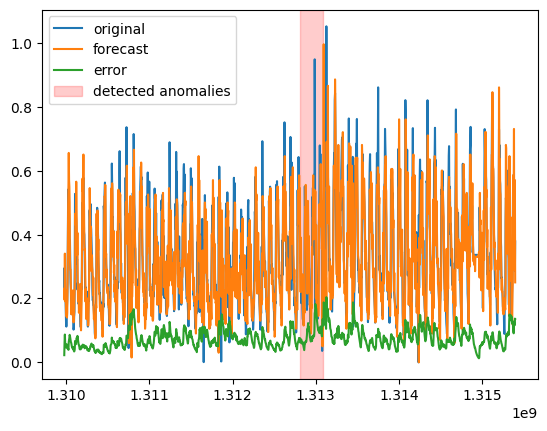

In [ ]:
index, y, yhat, errors, anomalies = list(map(context.get, ['target_index', 'y', 'y_hat', 'errors', 'anomalies']))

plt.plot(index, y, label='original')
plt.plot(index, yhat, label='forecast')
plt.plot(index, errors, label='error')

plt.axvspan(*anomalies[0][:2], color='r', alpha=0.2, label='detected anomalies')

plt.legend();

---